In [93]:
import matplotlib.pyplot as plt
#%matplotlib inline

import pandas as pd
import numpy as np
from math import ceil

In [94]:
import io
import requests
Content = requests.get("https://gitlab.com/erlang_matrices/erlang_matrix/raw/master/results.cvs").content
LoadedTable= pd.read_csv(io.StringIO(Content.decode('utf-8')),skipinitialspace=True,
                  names=['Test type', 'Width', 'Height','Matrix representation','No. of calls', 'Execution time'])

# Introduction

## Test scenarios descriptions

The LoadedTable contains statistics gathered from running the script that generates a matrix (Width x Height) and then 
runs with the [fprof](http://erlang.org/doc/man/fprof.html) following tests for each representation of matrix and sizes:

The tests categories:

 - one_rows_sums - sum of values from each row in the matrix
 
 - one_cols_sums - sum of values from each row in the matrix
 
 - get_value - gets each value from the matrix once separetly
 
 - set_value - sets each value from the matrix once separetly 



Matrixes are represented as follow:
 - [sofs](http://erlang.org/doc/man/sofs.html): Set of the sets module is a way of representing relations (in strictly mathematical sense). In this case the matrix is represented as a relation (a function) F where domain is constructed from coordinates which is related to the matrix entry value ({x,y} F Value).
 
 To get values in specific row we define equivalence relation aRb iff thera are {x,y1} F a {x,y2} F b.
 This relation divides antidomain in abbstract classes. If we sum elements belonging to the abstract class with element {x,_} we will get sum of the elements from this specific row. We use the same logic to receive abstrac classes for columns.
 
 
 - [digraph](http://erlang.org/doc/man/digraph.html): We have a directed graph where each value is stored in vertex with the coordinate {x,y}. Aside of that each column and row has dedicated vertex with edges from corresponding coordinate vertexes directed at it to speed up rows and columns sums calculations.
 
 
 - [array](http://erlang.org/doc/man/array.html): The matrix is represented as a tuple {Width, Height, Array}, where the array has size Width * Height, all operations are done with simply calculating positions of the values in the array.
 
 
 - big tuple: The matrix is represented as a tuple {Width, Height, BigTuple} where the BigTuple is tuple used in the same way as the Array from previous point (note: arrays indexing starts from 0).
 
 
 - [map](http://erlang.org/doc/man/maps.html): A quite fresh data structure in Erlang, we map coordinates {x,y} to values.
 
 
 - List of the lists: Each of sublists of the list contains elements representing  values in the row. Since it visually resembles a matrix, it is quite often abused by coders. Heavy usage of [lists](http://erlang.org/doc/man/lists.html) module.

 I have run tests on the square matrixes of sizes 50x50, 100x100, 1000x1000. For some of the 1000x1000 tests fprof logs exceeded the dedicated 2TB disk size. For those the values are missing.

In [95]:
LoadedTable.head()

Test type  Width  Height Matrix representation  No. of calls  \
0  one_rows_sums     50      50        matrix_as_sofs         20452   
1  one_rows_sums     50      50     matrix_as_digraph         20531   
2  one_rows_sums     50      50       matrix_as_array         18483   
3  one_rows_sums     50      50         matrix_as_map         13684   
4  one_rows_sums     50      50   matrix_as_big_tuple          5962   

   Execution time  
0          48.280  
1          59.981  
2          36.792  
3          42.790  
4          12.147

## Preliminary processing

In [96]:
from scipy import stats
from functools import reduce
AggregatedTable = (LoadedTable.groupby(['Test type','Matrix representation'])['Execution time']
                   .apply(list).reset_index(name='Execution Times List'))

Create aggregation table with execution time values for different size of matrixes stored in one list.

In [97]:
AggregatedTable.head()

Test type    Matrix representation          Execution Times List
0  get_value          matrix_as_array   [59.462, 232.601, 28018.33]
1  get_value      matrix_as_big_tuple  [25.176, 121.824, 12527.693]
2  get_value        matrix_as_digraph  [42.854, 211.419, 19704.339]
3  get_value  matrix_as_list_of_lists            [280.91, 2073.251]
4  get_value            matrix_as_map  [36.883, 159.307, 15976.373]

Each list should have 3 values, if one is missing it means it exceeded testing capability of my equipment, and can be considered infinite. Also add columns with minimum values, maximum values and harmonic averages (since standard average would be too susceptible to outliers here).

In [98]:
AggregatedTable['Harmonic Average'] = AggregatedTable['Execution Times List'].apply(
    lambda x: stats.hmean(x) if (len(x) == 3) else np.inf)

In [99]:
AggregatedTable['Max'] = AggregatedTable['Execution Times List'].apply(
    lambda x: max(x) if (len(x) == 3) else np.inf)

In [100]:
AggregatedTable['Min'] = AggregatedTable['Execution Times List'].apply(min)

In [101]:
AggregatedTable.head()

Test type    Matrix representation          Execution Times List  \
0  get_value          matrix_as_array   [59.462, 232.601, 28018.33]   
1  get_value      matrix_as_big_tuple  [25.176, 121.824, 12527.693]   
2  get_value        matrix_as_digraph  [42.854, 211.419, 19704.339]   
3  get_value  matrix_as_list_of_lists            [280.91, 2073.251]   
4  get_value            matrix_as_map  [36.883, 159.307, 15976.373]   

   Harmonic Average           Max      Min  
0        141.828134  2.801833e+04   59.462  
1         62.488602  1.252769e+04   25.176  
2        106.701803  1.970434e+04   42.854  
3               inf           inf  280.910  
4         89.679282  1.597637e+04   36.883

# Comparing operations

## Retrieving values

 Lets compare execution times for retrieving values.

In [102]:
GetValue = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='get_value']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

GetValue = GetValue.set_index('Matrix representation')

In [103]:
from jupyter_extensions.matplotlib.sawed_bar_plot import sawed_bar_plot

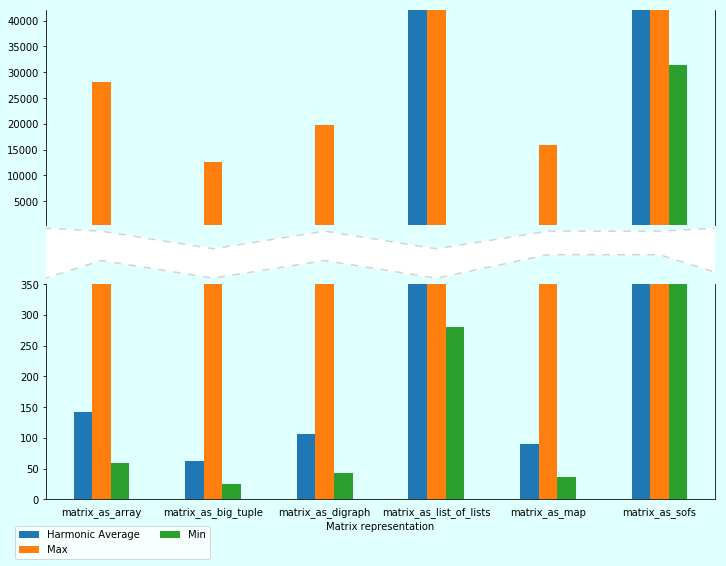

In [104]:
sawed_bar_plot(GetValue)

It occurs that lists of the list and set of sets implementation is extremely inefficient at retrieving values. 

The list of the lists sounds obvious since to get element in the middle we need to traverse to middle list representing row and then again in the row traverse to the middle element which gives O(n^2) access time.

The sofs occurs to be a trap, if you will read documentation you will see elegant (from mathematician point of view) relation algebra. But if you go inside the source code you will find that module extensively uses lists:fold which translates implementation to the list of lists scenario in the best case. We can probaly make the first conclusion and an advice here: Don't abuse sofs, remember map is actually relation too (precisely function, but noone can forbid you from returning lists or other containers). 

Other implementations look resonable. The are some suprises, like the better perfomance of big tuples than arrays.

Let see set_value functions perfomances.

## Storing values

In [105]:
SetValue = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='set_value']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )
SetValue = SetValue.set_index('Matrix representation')

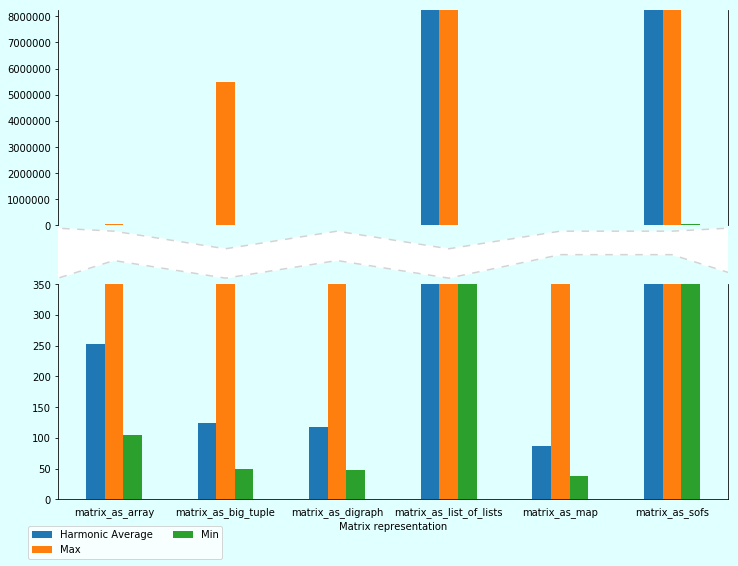

In [106]:
sawed_bar_plot(SetValue)

The lists of lists and softs are outclassed even for small matrixes like 10x10.

As we suspected the big_tuple is much worse at setting values since it is immutable and setting one value means copying whole tuple. We can notice that the array even if it is more efficient has some values above the rift, lets change a little perspective:

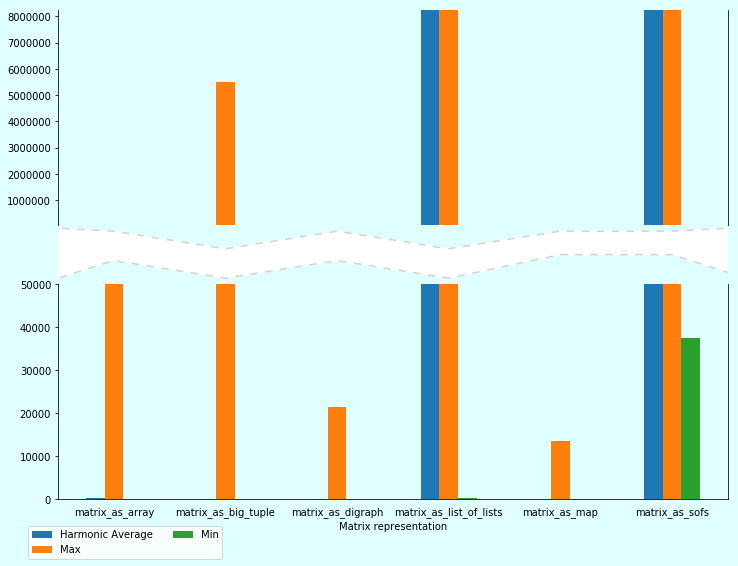

In [107]:
sawed_bar_plot(SetValue,50000)

Lets zoom a little bit to see small values.

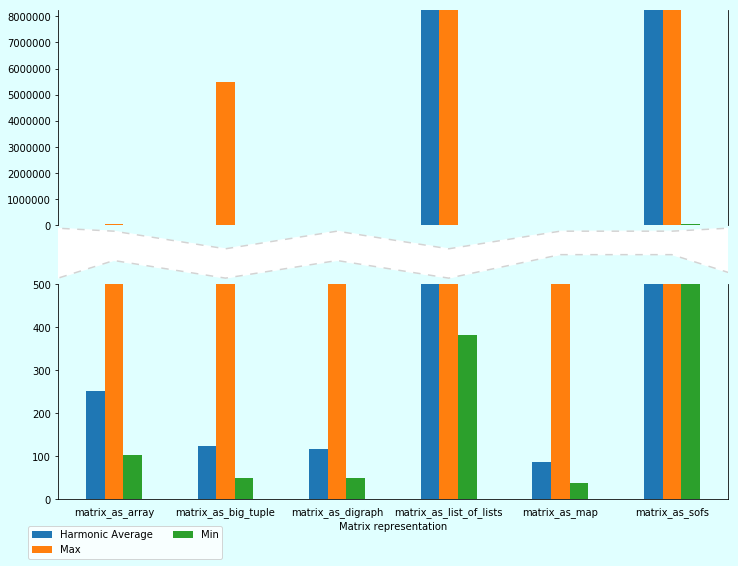

In [108]:
sawed_bar_plot(SetValue,500)

The array is much better than tuple, but both are magnitude worse than directed graph and matrix. It is now worth mentioning that digraph are implemented as an ets table which suggest a fixed overhead at first, but good efficiency for big tables. Still implementation with maps (build in ERTS) is faster even for 1000x1000 matrixes. We will investigate execution times increse further in the document.

Since digraph represented as an ets database is quite efficient is worth to ask and keep in mind a question: if we can craft matrix representation with ets table that will be more efficient than map. I will come back to this question at the end of this document.

The need for this small research occured during implemetation of a statistics gathering module. It was important to be able to calculate sums of specific counters. Usually in that case the best way is to make interface to some c or python application which support fast calculating. But this increases the complexity of the product, which should be usually avoided. Let check a performance of columns summation.

## Summing columns

In [109]:
OneColsSums = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='one_cols_sums']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

OneColsSums = OneColsSums.set_index('Matrix representation')

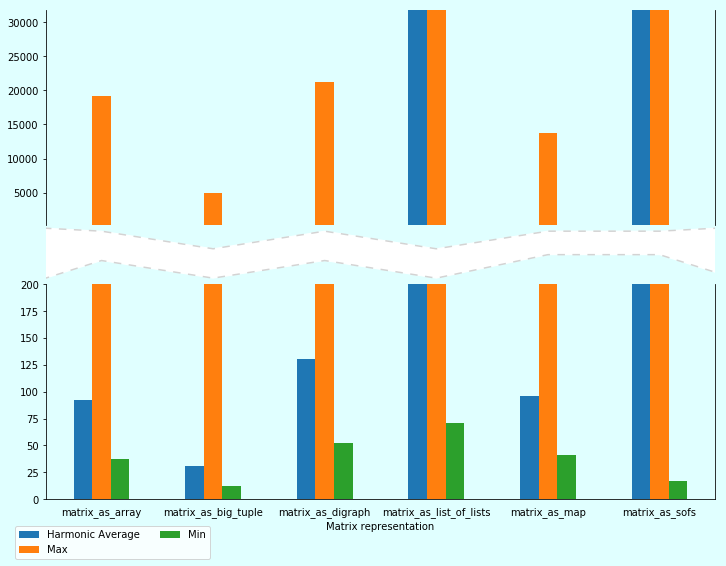

In [110]:
sawed_bar_plot(OneColsSums,200)

It is very confusing result, both array and tuple calculates the needed n indexes (in very C style) and sum extracted values (should be o(n^2), n calculations times n columns to calculate), still array is slower for big numbers than map which has to try to find value with hash (o(log(n)*n^2)), suggesting some inefficiency in implementation.

## Summing rows

Lets look at summing rows:

In [111]:
OneRowsSums = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='one_rows_sums']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

OneRowsSums = OneRowsSums.set_index('Matrix representation')

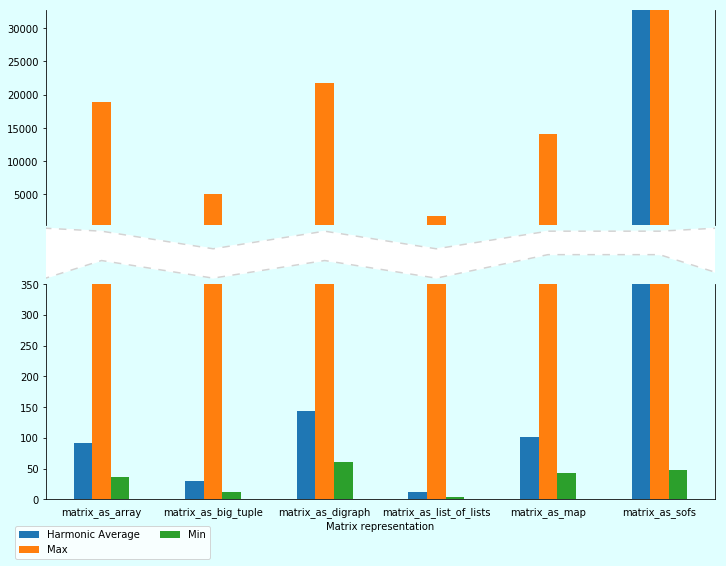

In [112]:
sawed_bar_plot(OneRowsSums)

Results are similar to the previous, with exception of the list of the list, which has obvious advantage since the dominating operation is summation of the list implemented as a linked list. Anyway since setting a value is extremly expensive, this implementation is still not really good.

# Matrix size comparisons

## Small matrixes

### Lets remove the sofs and the lists of lists from further considerations.

The next thing we should consider is which implementation is the best for small matrixes.

In [113]:
AggregatedTableRestricted = AggregatedTable[
            (AggregatedTable['Matrix representation']!='matrix_as_list_of_lists') &
            (AggregatedTable['Matrix representation']!='matrix_as_sofs')]
AggregatedTableRestricted.head()

Test type Matrix representation          Execution Times List  \
0      get_value       matrix_as_array   [59.462, 232.601, 28018.33]   
1      get_value   matrix_as_big_tuple  [25.176, 121.824, 12527.693]   
2      get_value     matrix_as_digraph  [42.854, 211.419, 19704.339]   
4      get_value         matrix_as_map  [36.883, 159.307, 15976.373]   
6  one_cols_sums       matrix_as_array    [37.541, 176.126, 19173.0]   

   Harmonic Average        Max     Min  
0        141.828134  28018.330  59.462  
1         62.488602  12527.693  25.176  
2        106.701803  19704.339  42.854  
4         89.679282  15976.373  36.883  
6         92.685699  19173.000  37.541

In [114]:
Minimums = (
    AggregatedTableRestricted  
    .loc[:,['Test type','Matrix representation','Min']]
    )
#Minimums.groupby(['Test type','Matrix representation'])
Minimums = Minimums.set_index(['Test type','Matrix representation'])
Minimums.head()

Min
Test type     Matrix representation        
get_value     matrix_as_array        59.462
              matrix_as_big_tuple    25.176
              matrix_as_digraph      42.854
              matrix_as_map          36.883
one_cols_sums matrix_as_array        37.541

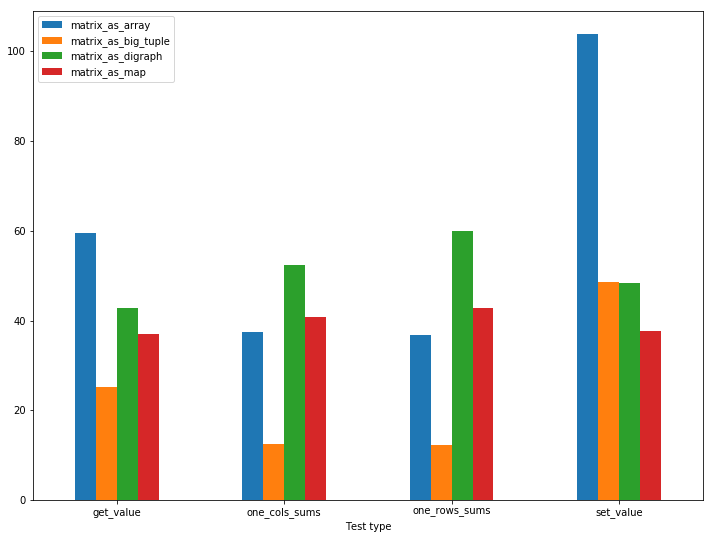

In [115]:
TestTypes = Minimums.index.get_level_values('Test type').unique().tolist()
#MatrixRepresentations = Minimums.index.get_level_values('Matrix representation').unique().tolist()
Plot = Minimums.unstack().plot(kind='bar',figsize=(12,9))
Plot.set_xticklabels(TestTypes,rotation="horizontal")
handles, labels=Plot.get_legend_handles_labels()
labels = [Label[6:-1] for Label in labels]
Plot.legend(handles,labels)
plt.show()

It occurs that for small values a big tuple is quite a good implementation, unlsess we are going to use our matrix for setting heavy tasks, in that case it is better to use map implementation.

Now we can see how those implementation efficiency looks for relatively(*) big 1000 x 1000 matrixes.

(*) If you really want something big you need to interface other programming language.

## Big matrixes

In [116]:
Maximums = (
    AggregatedTableRestricted  
    .loc[:,['Test type','Matrix representation','Max']]
    )
Maximums = Maximums.set_index(['Test type','Matrix representation'])
Maximums.head()

Max
Test type     Matrix representation           
get_value     matrix_as_array        28018.330
              matrix_as_big_tuple    12527.693
              matrix_as_digraph      19704.339
              matrix_as_map          15976.373
one_cols_sums matrix_as_array        19173.000

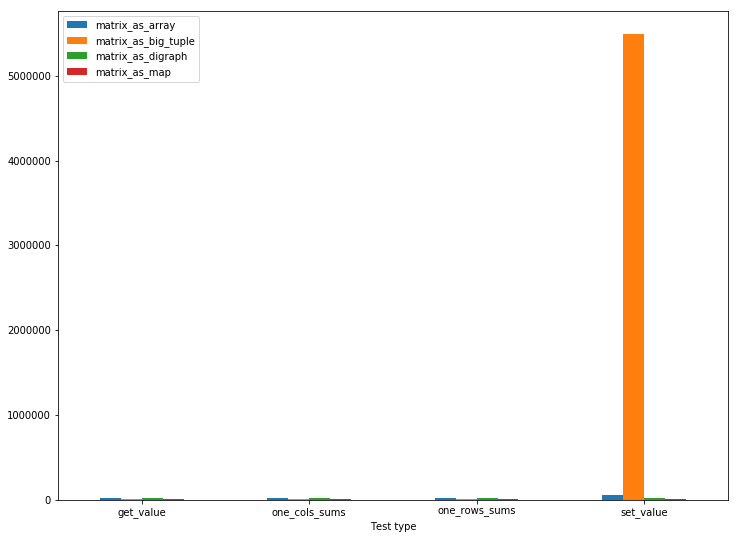

In [117]:
TestTypes = Maximums.index.get_level_values('Test type').unique().tolist()
Plot = Maximums.unstack().plot(kind='bar',figsize=(12,9))
Plot.set_xticklabels(TestTypes,rotation="horizontal")
handles, labels = Plot.get_legend_handles_labels()
labels = [Label[6:-1] for Label in labels]
Plot.legend(handles,labels)
plt.show()

It looks that set_value operations on the big tuple are overwhelmingly slow, to the level that they obfuscating our plot.
Lets remove them from the result and compare operations that left.

In [118]:
 Maximums.loc['set_value','matrix_as_big_tuple']=np.nan

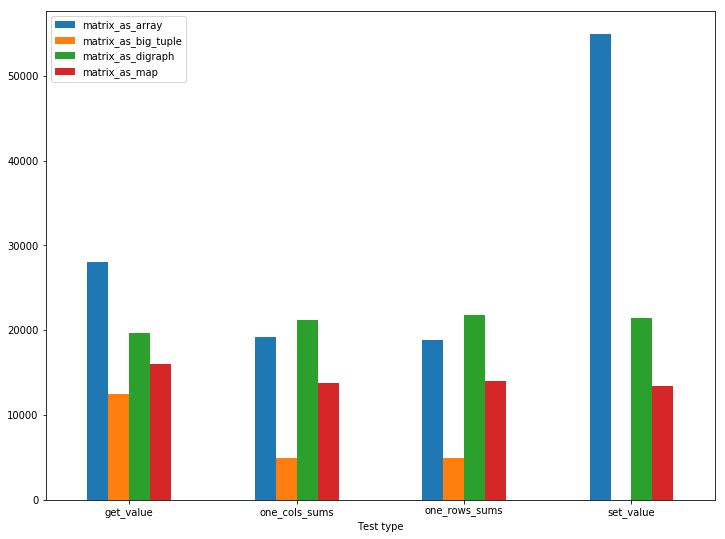

In [119]:
TestTypes = Maximums.index.get_level_values('Test type').unique().tolist()
Plot = Maximums.unstack().plot(kind='bar',figsize=(12,9))
Plot.set_xticklabels(TestTypes,rotation="horizontal")
handles, labels=Plot.get_legend_handles_labels()
labels = [Label[6:-1] for Label in labels]
Plot.legend(handles,labels)
plt.show()

So the big tuple with calculated index values occurs not to scale great. It is not suprising, since tuple is immutable, every time you set a new value you need to copy all of them, what makes it beyond redemption when it comes to storing operations.

Overall the map implementation is overall winner here, and it is overall recommendated implementation. But before we congratulate ourselves, we can notice that digraph implementation even if it is slower, maybe is only slower because overhead it implements over ets tables, and with futher increase of matrixes sizes it actually become better than maps.

## Growth acceleration estimation

To get a little more insight, that would help us estimate if this scenario happens we should find a way to compare how quickly the time consumption functions grow.

Lets try to figure out an acceleration of the resource consumption increase. 

For each index ([Test type, Matrix representation]) we are getting a function F that mapping the matrixes sizes:
 - 50 x 50 = 2500 cells = 25h(hecto)
 - 100 x 100 = 10k (kilo) = 100h
 - 1000 x 1000 = 1m (mega)
into the amount of resources consumed by particular test on that matrix. 

See the picture below:

![A picture should be here](https://raw.githubusercontent.com/flmath-dirty/matrixes_in_erlang/master/jupyter/angle_diff.svg.svg?sanitize=true)


We want to get a hint how fast the particular function growth will accelerate.

We will start from visualising scale of distances we are dealing here with:

 - 25hTo10k = 10k - 25h = <span style="color: violet">3</span> x  25h 
 - 10kTo1m  = 1m - 10k  = 99 x 10k = 99 x 4 x 25h = <span style="color: green">396</span> x 25h

For picture above we want to find out <span style="color: teal">the increase of the increase</span> or bind to it the angle <span style="color: red">R</span>. In our simplified calculus we can consider finding an increase as finding derivate. Since one of interpretations of derivate is actually tangens, what we can look for if we want to comparable estimates of <span style="color: red">R</span> we can use tan(<span style="color: red">R</span>) (since tanges is monotonic in $(\frac{-\pi}2, \frac\pi2)$).

But before we will try to find <span style="color: red">R</span> values, we need to notice that <span style="color: teal">the increase of the increase</span> to <span style="color: orange">the projected increase</span> ratio is depended on value of the 25h, so does the <span style="color: red">R</span>.

We want to remove this sensitivity to initial conditions, to do that we scale all the mappings, so the value of the 25h is the same for each of them.

In [120]:
pd.set_option('mode.chained_assignment',None)
AggregatedTableRestricted['Scaled Execution Times List'] = AggregatedTableRestricted['Execution Times List'].apply(
    lambda X: [(z * 100)/X[0] for z in X])
pd.set_option('mode.chained_assignment','warn')

In [121]:
AggregatedTableRestricted.head()

Test type Matrix representation          Execution Times List  \
0      get_value       matrix_as_array   [59.462, 232.601, 28018.33]   
1      get_value   matrix_as_big_tuple  [25.176, 121.824, 12527.693]   
2      get_value     matrix_as_digraph  [42.854, 211.419, 19704.339]   
4      get_value         matrix_as_map  [36.883, 159.307, 15976.373]   
6  one_cols_sums       matrix_as_array    [37.541, 176.126, 19173.0]   

   Harmonic Average        Max     Min            Scaled Execution Times List  
0        141.828134  28018.330  59.462  [100.0, 391.175877031, 47119.7235209]  
1         62.488602  12527.693  25.176  [100.0, 483.889418494, 49760.4583731]  
2        106.701803  19704.339  42.854  [100.0, 493.347178793, 45980.1628786]  
4         89.679282  15976.373  36.883  [100.0, 431.925277228, 43316.3598406]  
6         92.685699  19173.000  37.541  [100.0, 469.156389015, 51072.1611039]

Now by definition:

tan(<span style="color: blue">B</span>) = <span style="color: orange">the projected increase</span>/(<span style="color: green">396</span> x 25h)

tan(<span style="color: red">R</span>+<span style="color: blue">B</span>) = 10kTo1mValueIncrease/(<span style="color: green">396</span> x 25h)

Since denominator is the same we don't need to consider it here. Lets calculate those increases.

In [122]:
pd.set_option('mode.chained_assignment',None)
AggregatedTableRestricted['ProjectedIncrease'] = AggregatedTableRestricted['Scaled Execution Times List'].apply(
    lambda x: 396*(x[1]-x[0]))
AggregatedTableRestricted['ActualIncrease'] = AggregatedTableRestricted['Scaled Execution Times List'].apply(
    lambda x: x[2]-x[1])
pd.set_option('mode.chained_assignment','warn')

In [123]:
AggregatedTableRestricted.head()

Test type Matrix representation          Execution Times List  \
0      get_value       matrix_as_array   [59.462, 232.601, 28018.33]   
1      get_value   matrix_as_big_tuple  [25.176, 121.824, 12527.693]   
2      get_value     matrix_as_digraph  [42.854, 211.419, 19704.339]   
4      get_value         matrix_as_map  [36.883, 159.307, 15976.373]   
6  one_cols_sums       matrix_as_array    [37.541, 176.126, 19173.0]   

   Harmonic Average        Max     Min            Scaled Execution Times List  \
0        141.828134  28018.330  59.462  [100.0, 391.175877031, 47119.7235209]   
1         62.488602  12527.693  25.176  [100.0, 483.889418494, 49760.4583731]   
2        106.701803  19704.339  42.854  [100.0, 493.347178793, 45980.1628786]   
4         89.679282  15976.373  36.883  [100.0, 431.925277228, 43316.3598406]   
6         92.685699  19173.000  37.541  [100.0, 469.156389015, 51072.1611039]   

   ProjectedIncrease  ActualIncrease  
0      115305.647304    46728.547644  
1      152020.209724    49276.568955  
2      155765.482802    45486.815700  
4      131442.409782    42884.434563  
6      146185.930050    50603.004715

We have tan(<span style="color: red">R</span>+<span style="color: blue">B</span>) and tan(<span style="color: blue">B</span>), but we want to calculate tan(<span style="color: red">R</span>).

Fortunately there are identities that can help us with that.

In [124]:
import sympy as sp
R, B = sp.symbols('R B')
tanRplusB = sp.expand_trig(sp.tan(R + B))
tanRplusB

(tan(B) + tan(R))/(-tan(B)*tan(R) + 1)

We want to experess tan(<span style="color: red">R</span>).

SymPy trigonometric expansion/simplification functions would give us quite complicated answers (including atan function). But we just want to treat tan(<span style="color: red">R</span>) as rational function of the other tanges, so we make substitution.
 - tan(<span style="color: red">R</span>+<span style="color: blue">B</span>) = C
 - tan(<span style="color: blue">B</span>) = B
 - tan(<span style="color: red">R</span>) = R

In [125]:
Ratio= tanRplusB.subs(sp.tan(R),R).subs(sp.tan(B),B)
C = sp.symbols('C')
RatioSolution = sp.solve(sp.Eq(Ratio , C),R)
RatioSolution

[(-B + C)/(B*C + 1)]

In [126]:
FinalSolution = RatioSolution[0].subs(B,sp.tan(B)).subs(C,sp.tan(R+B))
FinalSolution

(-tan(B) + tan(B + R))/(tan(B)*tan(B + R) + 1)

Double check that result is actually valid:

In [127]:
sp.simplify(FinalSolution-sp.tan(R)) == 0

True

Lets apply the result equation on our data:

In [128]:
pd.set_option('mode.chained_assignment',None)
AggregatedTableRestricted['TanB'] = AggregatedTableRestricted['ProjectedIncrease'].apply(
    lambda x: x/396)
AggregatedTableRestricted['TanAplusB'] = AggregatedTableRestricted['ActualIncrease'].apply(
    lambda x: x/396)
AggregatedTableRestricted['TanA'] = (
    (AggregatedTableRestricted['TanAplusB']-AggregatedTableRestricted['TanB'])/((AggregatedTableRestricted['TanAplusB']*AggregatedTableRestricted['TanB'])+1))
pd.set_option('mode.chained_assignment','warn')

In [129]:
Diffs = (
    AggregatedTableRestricted  
    .loc[:,['Test type','Matrix representation','TanA']]
    )
#Minimums.groupby(['Test type','Matrix representation'])
Diffs = Diffs.set_index(['Test type','Matrix representation'])


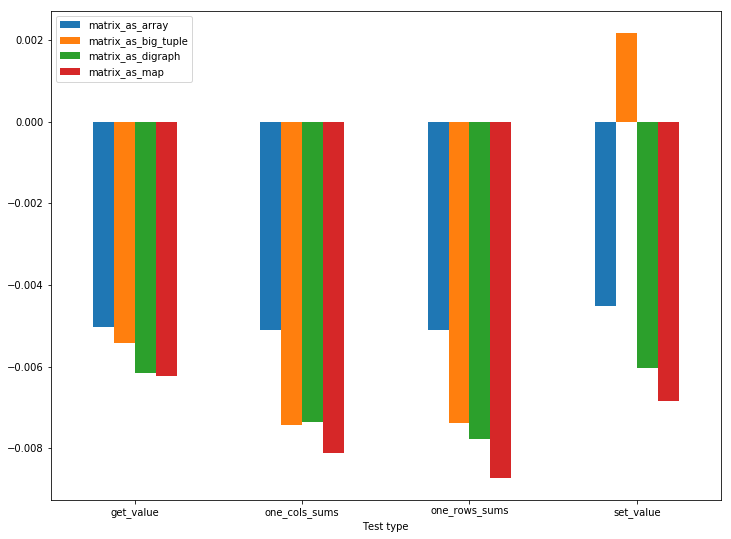

In [130]:
TestTypes = Diffs.index.get_level_values('Test type').unique().tolist()
Plot = Diffs.unstack().plot(kind='bar',figsize=(12,9))
Plot.set_xticklabels(TestTypes,rotation="horizontal")
handles, labels=Plot.get_legend_handles_labels()
labels = [Label[7:-1] for Label in labels]
Plot.legend(handles,labels)
plt.show()

Bars in this plot represent growth acceleration, which is related to the second derivative of the function.

# Conclusion

It looks that maps implementation is actually the best choice. It is also hearth-warming that majority of operations execution times growth is slower than a linear one.

What left for another articles are implementations with ets tables with different keys formats, which I will compare to our map representation and also map with different formats of keys (key as list, binary ets. instead of tuple).
I'm also considering implementing matrix multiplication instead columns and rows sums (those operations are comparable, if it comes to complexity).

After that I have plans to more sophisticated implementations using Erlang main advantage, possibility to store values in small processes.